# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_n_snps_used_and_log"
    / "gls-1000g_mashr-full_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-1000g_mashr-full_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-1000g_mashr-full_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-1000g_mashr-full_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-1000g_mashr-full_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-1000g_mashr-full_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-1000g_mashr-full_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.001712,0.005523,-0.309969,0.756595,0.621703,random.pheno988
1,LV2,0.001147,0.003810,0.300911,0.763492,0.381746,random.pheno988
2,LV3,-0.009326,0.008156,-1.143476,0.252884,0.873558,random.pheno988
3,LV4,-0.008623,0.008519,-1.012223,0.311470,0.844265,random.pheno988
4,LV5,0.001799,0.012106,0.148601,0.881873,0.440936,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.05193819655521783

# QQ-plot

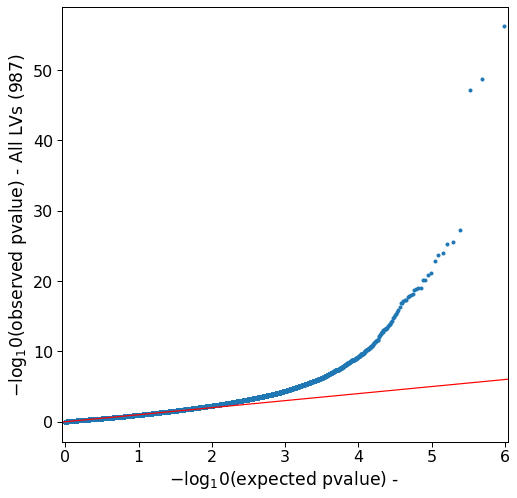

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.001,0.006,0.024
1,LV10,0.018,0.074,0.118
2,LV100,0.009,0.031,0.063
3,LV101,0.026,0.100,0.164
4,LV102,0.008,0.052,0.093


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.015404,0.051938,0.093324
std,0.019123,0.038384,0.055556
min,0.000000,0.000000,0.000000
25%,0.003000,0.025000,0.057500
50%,0.013000,0.053000,0.098000
75%,0.020000,0.072000,0.126000
max,0.245000,0.345000,0.405000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(34, 4)

,lv,1,5,10
214,LV292,0.008,0.049,0.092
442,LV498,0.017,0.049,0.091
15,LV112,0.007,0.049,0.103
345,LV41,0.014,0.049,0.076
588,LV629,0.011,0.049,0.096
94,LV184,0.016,0.049,0.098
282,LV353,0.012,0.049,0.101
478,LV53,0.011,0.049,0.108
644,LV68,0.014,0.049,0.092
492,LV542,0.007,0.050,0.083


,lv,1,5,10
97,LV187,0.009,0.050,0.090
727,LV754,0.010,0.050,0.095
62,LV155,0.012,0.050,0.099
784,LV805,0.009,0.050,0.101
686,LV717,0.012,0.050,0.097
486,LV537,0.016,0.050,0.089
507,LV556,0.013,0.051,0.100
851,LV866,0.018,0.051,0.087
12,LV11,0.009,0.051,0.088
361,LV424,0.014,0.051,0.095


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(367, 4)

,lv,1,5,10
153,LV237,0.076,0.150,0.221
734,LV760,0.083,0.151,0.236
436,LV492,0.062,0.165,0.234
255,LV329,0.112,0.168,0.203
466,LV519,0.085,0.168,0.235
289,LV36,0.104,0.174,0.222
349,LV413,0.101,0.177,0.228
549,LV594,0.109,0.181,0.241
297,LV367,0.113,0.191,0.240
24,LV120,0.091,0.192,0.251


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.010623,0.008586,1.237158,0.216074,0.108037,random.pheno988
1031,LV45,0.002806,0.008648,0.324491,0.745577,0.372788,random.pheno589
2018,LV45,0.001060,0.008574,0.123597,0.901638,0.450819,random.pheno385
3005,LV45,0.003930,0.008678,0.452861,0.650664,0.325332,random.pheno5
3992,LV45,-0.018114,0.008598,-2.106692,0.035183,0.982409,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.046

In [32]:
show_prop(results, 0.05)

0.106

In [33]:
show_prop(results, 0.10)

0.153

In [34]:
show_prop(results, 0.15)

0.2

In [35]:
show_prop(results, 0.20)

0.237

### QQplot

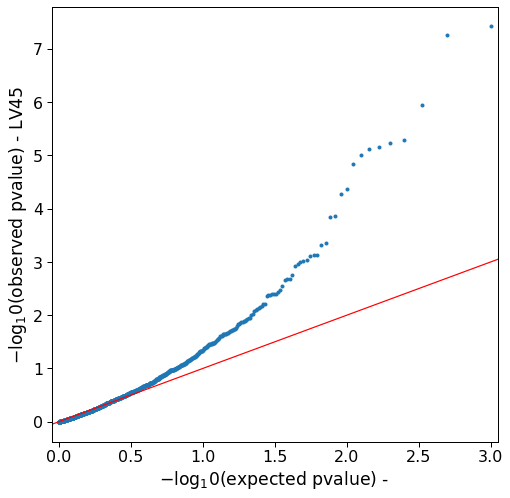

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.015419,0.010662,1.446167,0.148179,0.074089,random.pheno988
1220,LV234,0.003493,0.010739,0.325304,0.744961,0.372481,random.pheno589
2207,LV234,-0.004686,0.010647,-0.440158,0.659837,0.670081,random.pheno385
3194,LV234,0.004880,0.010776,0.452856,0.650668,0.325334,random.pheno5
4181,LV234,0.003652,0.010681,0.341955,0.732396,0.366198,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.015

In [43]:
show_prop(results, 0.05)

0.057

In [44]:
show_prop(results, 0.10)

0.104

In [45]:
show_prop(results, 0.15)

0.154

In [46]:
show_prop(results, 0.20)

0.196

### QQplot

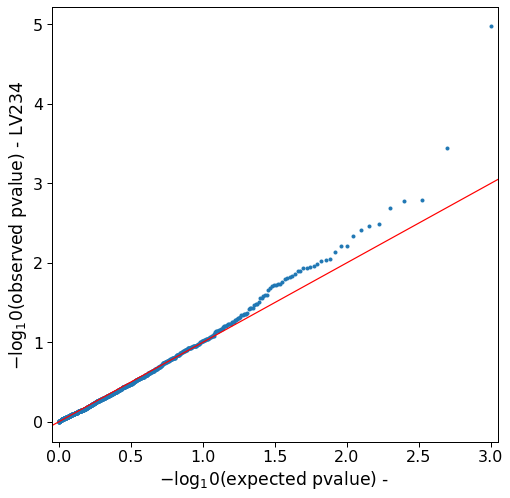

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.000713,0.010901,0.065428,0.947835,0.473918,random.pheno988
1833,LV847,-0.003062,0.010977,-0.278892,0.780337,0.609832,random.pheno589
2820,LV847,-0.013294,0.010882,-1.221638,0.221889,0.889055,random.pheno385
3807,LV847,-0.004205,0.011016,-0.381740,0.702667,0.648667,random.pheno5
4794,LV847,0.006593,0.010918,0.603848,0.545966,0.272983,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.009

In [54]:
show_prop(results, 0.05)

0.055

In [55]:
show_prop(results, 0.10)

0.091

In [56]:
show_prop(results, 0.15)

0.135

In [57]:
show_prop(results, 0.20)

0.17

### QQplot

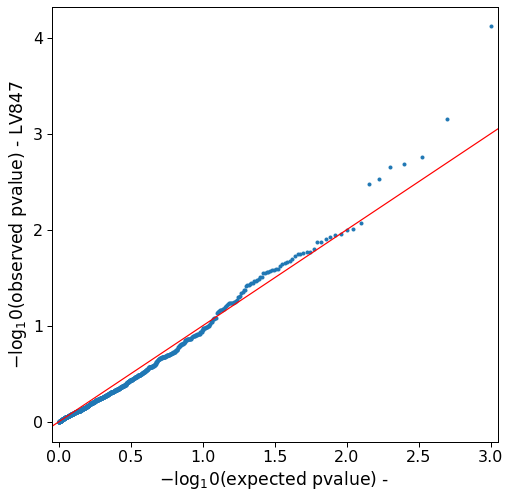

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.022808,0.008872,-2.570888,0.010166,0.994917,random.pheno988
1096,LV110,-0.012944,0.008937,-1.448262,0.147592,0.926204,random.pheno589
2083,LV110,-0.008659,0.008862,-0.977110,0.328552,0.835724,random.pheno385
3070,LV110,-0.008369,0.008969,-0.933063,0.350822,0.824589,random.pheno5
4057,LV110,0.009062,0.008890,1.019293,0.308102,0.154051,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.016

In [65]:
show_prop(results, 0.05)

0.051

In [66]:
show_prop(results, 0.10)

0.095

In [67]:
show_prop(results, 0.15)

0.142

In [68]:
show_prop(results, 0.20)

0.19

### QQplot

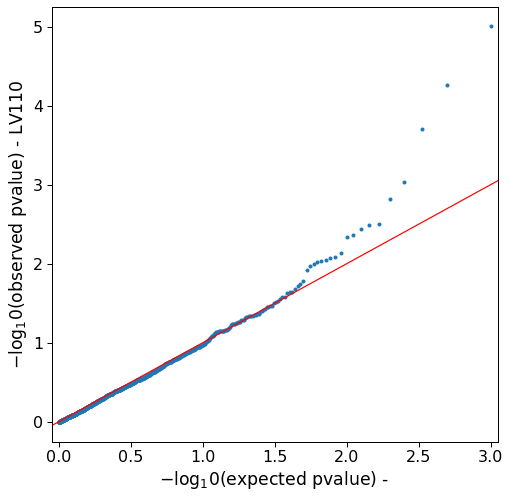

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.015733,0.010252,1.534617,0.124927,0.062463,random.pheno988
1755,LV769,-0.006911,0.010326,-0.669227,0.503374,0.748313,random.pheno589
2742,LV769,-0.010744,0.010237,-1.049464,0.294004,0.852998,random.pheno385
3729,LV769,-0.013874,0.010361,-1.339047,0.180603,0.909699,random.pheno5
4716,LV769,-0.017346,0.010269,-1.689234,0.091223,0.954388,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.059

In [76]:
show_prop(results, 0.05)

0.146

In [77]:
show_prop(results, 0.10)

0.209

In [78]:
show_prop(results, 0.15)

0.265

In [79]:
show_prop(results, 0.20)

0.321

### QQplot

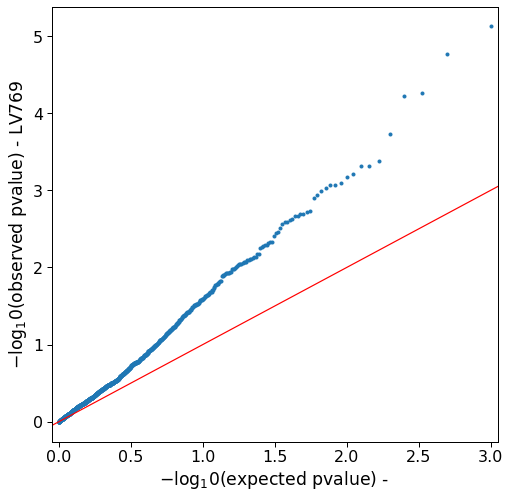

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.004753,0.012526,0.379436,0.704377,0.352188,random.pheno988
1786,LV800,-0.013088,0.012614,-1.037602,0.299494,0.850253,random.pheno589
2773,LV800,-0.004013,0.012507,-0.320841,0.748341,0.625829,random.pheno385
3760,LV800,-0.015506,0.012657,-1.225071,0.220593,0.889703,random.pheno5
4747,LV800,-0.009723,0.012547,-0.774979,0.438381,0.780810,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.01

In [87]:
show_prop(results, 0.05)

0.047

In [88]:
show_prop(results, 0.10)

0.106

In [89]:
show_prop(results, 0.15)

0.153

In [90]:
show_prop(results, 0.20)

0.2

### QQplot

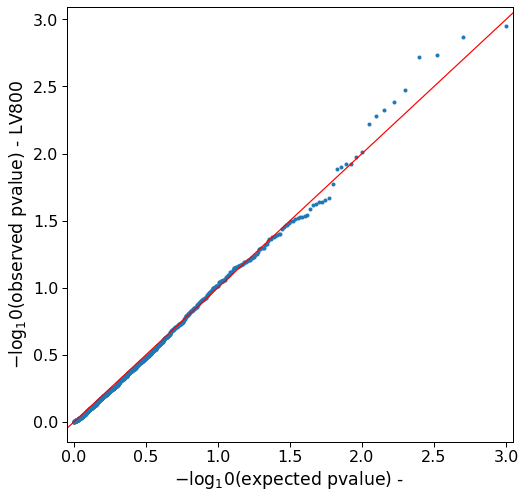

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
214,LV292,0.008,0.049,0.092
442,LV498,0.017,0.049,0.091
15,LV112,0.007,0.049,0.103
345,LV41,0.014,0.049,0.076
588,LV629,0.011,0.049,0.096
94,LV184,0.016,0.049,0.098
282,LV353,0.012,0.049,0.101
478,LV53,0.011,0.049,0.108
644,LV68,0.014,0.049,0.092
492,LV542,0.007,0.050,0.083


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,0.003034,0.007175,0.422792,0.672461,0.336231,random.pheno988
1398,LV412,-0.004618,0.007226,-0.639113,0.522772,0.738614,random.pheno589
2385,LV412,0.004335,0.007164,0.605158,0.545095,0.272548,random.pheno385
3372,LV412,-0.002305,0.007251,-0.317922,0.750555,0.624723,random.pheno5
4359,LV412,0.007539,0.007187,1.049061,0.294189,0.147095,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.003

In [100]:
show_prop(results, 0.05)

0.017

In [101]:
show_prop(results, 0.10)

0.052

In [102]:
show_prop(results, 0.15)

0.091

In [103]:
show_prop(results, 0.20)

0.137

### QQplot

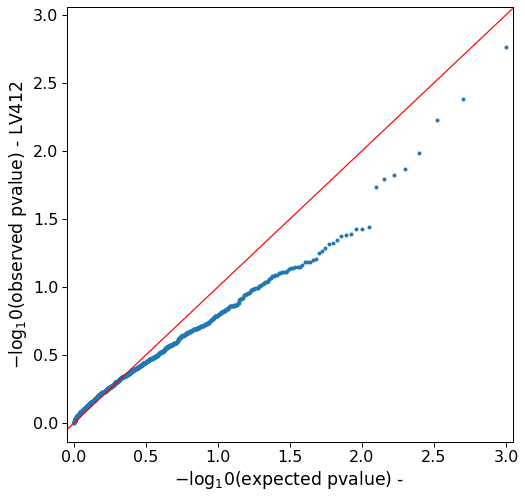

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.017299,0.009678,-1.787511,0.073902,0.963049,random.pheno988
1043,LV57,0.000562,0.009749,0.057635,0.954041,0.477020,random.pheno589
2030,LV57,0.020208,0.009662,2.091518,0.036521,0.018260,random.pheno385
3017,LV57,-0.003967,0.009782,-0.405535,0.685098,0.657451,random.pheno5
4004,LV57,-0.000994,0.009696,-0.102493,0.918368,0.540816,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.009

In [111]:
show_prop(results, 0.05)

0.058

In [112]:
show_prop(results, 0.10)

0.109

In [113]:
show_prop(results, 0.15)

0.152

In [114]:
show_prop(results, 0.20)

0.208

### QQplot

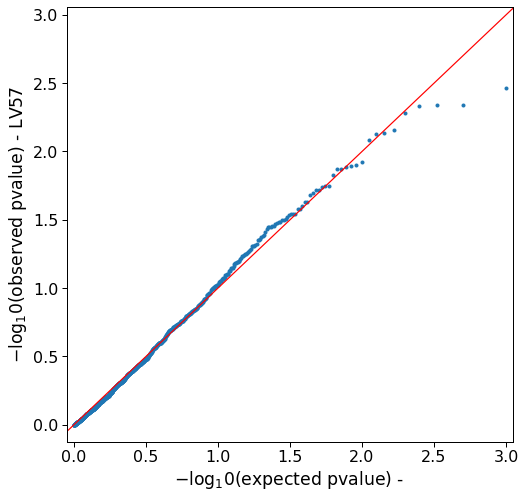

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.005899,0.010779,-0.547260,0.584219,0.707890,random.pheno988
1633,LV647,0.008319,0.010855,0.766365,0.443487,0.221744,random.pheno589
2620,LV647,0.013425,0.010761,1.247542,0.212244,0.106122,random.pheno385
3607,LV647,-0.000075,0.010893,-0.006881,0.994510,0.502745,random.pheno5
4594,LV647,0.019363,0.010794,1.793829,0.072887,0.036444,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.021

In [122]:
show_prop(results, 0.05)

0.078

In [123]:
show_prop(results, 0.10)

0.119

In [124]:
show_prop(results, 0.15)

0.163

In [125]:
show_prop(results, 0.20)

0.21

### QQplot

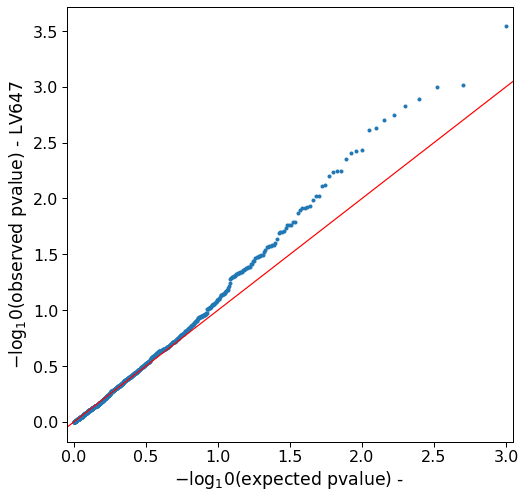

In [126]:
qqplot_unif(results)